# How to consider incoming travelers in your SEIR model

This notebook will show you how you can take incoming travelers into consideration within the framework of your SEIR model. 

Let's start by importing the required packages

In [279]:
import numpy as np
import os
import scipy.io
import seaborn as sns

import matplotlib.pyplot as plt
current = os.getcwd()
import pandas as pd
from matplotlib import ticker
filename = os.path.basename(current)[:-3]

In this example, we are focusing on travel within the United States. In particular, we are interested to find out how incoming travelers affect the disease dynamics in a specific region of interest. 

In the cell below, we are importing a dataframe (fancy word for a table) which contains useful COVID-related information from every state. For this exercise, we provided all necessary numbers for you for a specific time point. 

First, we plot the table to show you its structure and contents.

In [280]:
#%% Loading data

# Summary table with COVID-related info - from a specific time point
df_summ= pd.read_csv('today_case.csv')

# Let's see what the table df_summ looks like
df_summ[['Locations','Population','S_0','E_0','I_0','R_0','Rt','beta','UG1','UG2','UG3','UG4','UG5']]

,Locations,Population,S_0,E_0,I_0,R_0,Rt,beta,UG1,UG2,UG3,UG4,UG5
0,Alabama,4903185,0.957460,0.000411,0.004105,0.038024,1.269367,0.195287,2,3,5,5,1
1,Alaska,731545,0.970861,0.000822,0.008224,0.020093,1.273250,0.195885,4,2,4,3,1
2,Arizona,7278717,0.963486,0.000320,0.003199,0.032995,1.086398,0.167138,42,24,23,21,10
3,Arkansas,3017825,0.958284,0.000549,0.005486,0.035681,0.571183,0.087874,3,4,3,6,0
4,California,39512223,0.974643,0.000192,0.001916,0.023249,1.443353,0.222054,534,622,674,682,317
5,Colorado,5758736,0.975123,0.000697,0.006969,0.017211,1.224451,0.188377,17,40,33,42,17
6,Connecticut,3565287,0.976321,0.000402,0.004025,0.019251,0.117977,0.018150,13,14,16,18,5
7,Delaware,973764,0.971864,0.000294,0.002940,0.024902,1.800537,0.277006,3,3,2,1,2
8,District of Columbia,705749,0.974071,0.000180,0.001795,0.023955,0.100391,0.015445,4,9,3,13,2
9,Florida,21477737,0.960017,0.000307,0.003067,0.036610,2.154664,0.331487,46,45,58,31,10


As you can see, the table has 51 rows for the 50 states plus the federal district of Columbia (Washington, D.C.). For each location, it gives us

- the **total population**
- the normalized values for the compartments **S,E,I and R at a specific point in time**
- the **reproduction number R(t)**
- the **contact rate beta**

All of these model parameters come from fitting our SEIR model to case data from all states up to a specific time point (here beginning of July) and we will use them as our start values and model parameters in this notebook.

The last column contains **fictional passenger data** we created for the purpose of this notebook exercise.
How do we interpret this passenger data? Let's say we are interested in the disease dynamics in California. The information from the last column would then mean that over the course of one year (365 days),  𝑥  people are traveling to California from the respective other locations. For example, we would have 209205 passengers traveling from Arizona to California.

We can relate what we have here with graph theory where, for instance, susceptible population evolves in time as follows,
$\dot{S}_i = - \sum_j{\vartheta L_{ij} S_j - \beta S_i I_i}$. 
where $i,j= Alabama, Alaska ... Wyoming$. 
Incoming passengers data in our table correspond to $- \vartheta L_{ij}$ in the equation above, where $i$ is the state we consider and $j= Alabama, Alaska ... Wyoming$. So, we have the information from only the row $i$ of transport matrix $L_{ij}$.

For the purpose of this exercise, we will assume that this fictional incoming passenger data stays the same whether our region of interest is California or Texas or Utah. Even though in real life that is obviously not true.

In the next cell, we are saving the incoming passenger data and the contact rates beta for every state in numpy arrays (vectors). In addition, we are calculating the expected number of incoming infectious passengers for each state, so that we can implement selective quarantine strategies.  

In [281]:
# incoming passenger data 
incoming = df_summ['UG1']# +df_summ['UG2']+df_summ['UG3']+df_summ['UG4']+df_summ['UG5']
# A_all = incoming.to_numpy()
#calculate the incoming infectious as I_0*Incoming_passenger
df_summ['Incoming Infectious']= df_summ['I_0'].mul(incoming)
# contact rates
fb = df_summ['beta'].to_numpy()
# Number of locations
nodes = len(A_all)

In [282]:
new_population = sum(incoming)
new_population

1458

Let's have a look at what our distribution of infectious passengers from the different locations looks like.

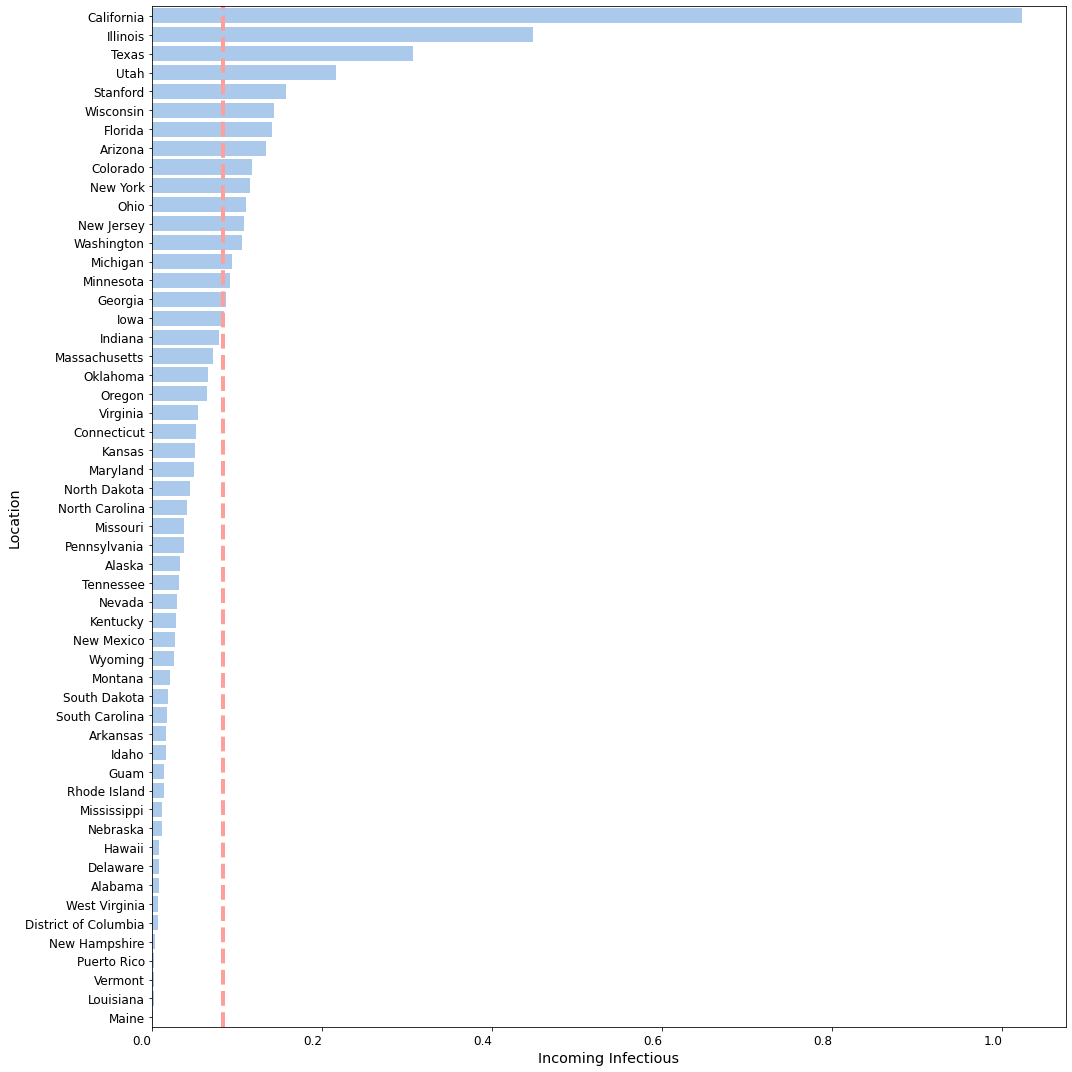

In [283]:
Label = 'Incoming Infectious'
df_pass = df_summ.sort_values(by=[Label], ascending=False)
#Plot
f, ax = plt.subplots(figsize=(15, 15)) 
sns.set_color_codes("pastel")
sns.barplot(x=Label, y="Locations", data=df_pass,
            label="Total", color="b")

ax.axvline(df_summ['Incoming Infectious'].mean(), lw=4, ls='--', color='r')
# show_values_on_bars(ax, "h", 0.3)

plt.ylabel("Location", fontsize='x-large')
plt.xlabel(Label, fontsize='x-large')
plt.xticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.yticks(
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.tight_layout()

Next, we will define the settings for the forecasting in our region of interest. 
- As always, we need to define a time increment `dt` for the explicit integration scheme of our ODEs
- `Tmax` defines how far into the future we want to predict
- `idx` defines which state is our region of interest. Check in the table above which state has which index.
- `Flag_Iso` is a flag that can be set to either true or false depending on whether we want to apply quarantine to all incoming passengers (`Flag_iso=False`) or only to passengers from 'high-risk' states (`Flag_Iso=True`).


- `Af`, `Cf`, `fa` and `fc` are the disease-specific model parameters we are assuming to be the same for all states
- `fb[idx]` determines the contact rate we are using for forecasting in our location of interest. 
> - we can either keep this at the value `beta` from the table which came from fitting the SEIR model to data from beginning of July
> - or we can prescribe different values of `R0_fin` or `fb[idx]` here, which would represent different scenarios in our region of interest and could be used to study the effect of increasing/decreasing the contact rate through different measures.

In [284]:
#%% ################### Settings ##############################################
dt     = 0.01
Tmax   = 14
isteps = int(Tmax/dt)

# Index of State of consideration
idx = 53

# Flag for apply quarantine to states with incoming infectious passengers higher than mean numbers only
Flag_Iso = False

Af = 2.56430
Cf = 14

fa = 1/Af
fc = 1/Cf

## Here you can change the contact-rate for forecasting for our region of interest (Assumption)
## if you want to make forward predictions for different scenarios of our local reproduction number
R0_fin = 1.5  ## assumption
fb[idx] = R0_fin * fc 
fb[idx]


0.10714285714285714

Here we initialize the arrays in which we will save the predicted S,E,I,R for each location and each time point.

In our vector containing the incoming passenger numbers `A_all`, we have to set the entry corresponding to our region of interest to zero, because traveling within a state does not affect our disease dynamics if we only observe them at the whole-state level.

In [285]:
#%% ############## initialize model parameters and seed ######################

# Define output shape of the SEIR model
Sout= np.empty((isteps,nodes))
Eout= np.empty((isteps,nodes))
Iout= np.empty((isteps,nodes))
Rout= np.empty((isteps,nodes))

# Clear incoming passengers for location of consideration
A_all[idx] = 0

Now we define the function to forecast our SEIR compartments in all states including our region of interest. 

### quarantine scale and quarantined states
The function gives us the option to define a `quarantine_scale` which determines the extent to which travelers are complying with a 14-day quarantine after traveling. `quarantine_scale = 1.0` would mean  travelers are fully quarantining, `quarantine_scale = 0.0` would mean travelers are violating the quarantine. 

Although it is a natural choice to quarantine passengers from all states, a more interesting scenerio would be to quarantine only the ones with higher risk. To find out these states we calculate incoming infectious passengers for each state and the mean value of it in `mean_incoming_infectious`. If `Flag_Iso=True`, we apply the `quarantine_scale` only to the states associated with infectious passengers higher than average. 

### compartment additions from incoming travelers
In order to calculate how many people are added to each of the compartments by the incoming travelers, we take a dot product between the array containing all compartment values at each location (`Sarr`,`Earr`,...) and the array containing the daily incoming traveler numbers `A_all_scaled`. The result will be a scalar value of how many people are added to which compartment. We need to normalize this value by the current population.

We only want to add these numbers to the compartments of our location of interest, which is why we multiply with a scaffold vector `Scaffold` containing zeros at all but our index of interest.

### explicit integration scheme for S, E, I and R
We then solve the rest of the model in a by now well-known fashion, using explicit Euler forward. The only difference to the homework is that to each compartment of our location of interest, we are adding the amount that was brought in through incoming travelers.

### assumptions
Since we are only using a slice of the adjacency matrix here and not the full adjacency and Laplacian matrix as shown in lecture, we are making the following assumptions: 
- no one is traveling from our region of interest to other states
- no one is traveling in between the other states

In [286]:
#%% ################## define SEIR forecasting function ############################

def forecasting(quarantine_scale,A_all,fb):
    
    Sarr = df_summ['S_0'].to_numpy()
    Earr = df_summ['E_0'].to_numpy()
    Iarr = df_summ['I_0'].to_numpy()
    Rarr = df_summ['E_0'].to_numpy()

    Daily_normalization = 1  # In this case passenger data are accumulated from 1 year

    #apply quarantine to states with incoming infectious passengers higher than mean numbers
    mean_incoming_infectious= df_summ['Incoming Infectious'].mean(axis=0)
    q_states = df_summ['Incoming Infectious']>mean_incoming_infectious
    #
    q_scaled_states = np.zeros_like(A_all)
    
    if Flag_Iso:
        q_scaled_states[q_states] = quarantine_scale
    else:
        q_scaled_states = quarantine_scale* np.ones_like(A_all)
   
    #
    A_all_scaled = ((1-q_scaled_states) * A_all)/Daily_normalization
    
    A_all_pop =  A_all/Daily_normalization
    pop_daily_add = np.sum(A_all_pop)
    
    # Population of location of consideration
    pop = df_summ['Population'].to_numpy()[idx]
    pop_new = pop
    
    # Define an array to add SEIR values only to location of consideration
    Scaffold = np.zeros_like(Rarr)
    Scaffold[idx] = 1.0
    
    for s in range(0,isteps):
    
     
        # Summing up incoming passenger categories
        # Sum of all daily incoming passengers is added to the total population in our region of interest
        S_add = np.dot(Sarr,A_all_scaled) * Scaffold/(pop_new)
        E_add = np.dot(Earr,A_all_scaled) * Scaffold/(pop_new)
        I_add = np.dot(Iarr,A_all_scaled) * Scaffold/(pop_new)
        R_add = np.dot(Rarr,A_all_scaled) * Scaffold/(pop_new)
          
        
        # Calculating the SEIR model, while adding daily passenger influx
        SarrNew = Sarr + (S_add - fb * Sarr * Iarr)* dt 
        EarrNew = Earr + (E_add + (fb * Sarr * Iarr) - fa*Earr )* dt 
        IarrNew = Iarr + (I_add + fa * Earr - fc * Iarr)* dt 
        RarrNew = Rarr + (R_add +  fc * Iarr )* dt 
    
        
    
        Sarr, Earr, Iarr, Rarr = SarrNew, EarrNew, IarrNew, RarrNew
    
        Sout[s,:] = Sarr
        Eout[s,:] = Earr
        Iout[s,:] = Iarr
        Rout[s,:] = Rarr
        
        pop_new = pop_new + pop_daily_add*dt
        
    confirmed = pop_new*Iout[:,idx] + pop_new*Rout[:,idx]
  
    return confirmed

We predict the evolution of confirmed cases for four different quarantine scenarios which will be compared in the graph at the end of this notebook.

In [287]:
#%% Function calls
    
    
confirmed = forecasting(0,A_all,fb)
    
confirmed_50 = forecasting(0.5,A_all,fb)

confirmed_75 = forecasting(0.75,A_all,fb)

confirmed_95 = forecasting(0.95,A_all,fb)

In [288]:
quarantine_sc = 0.95
## RO = 1.5
R0_fin = 1.5 ## assumption
fb[idx] = R0_fin * fc 
confirmed_75_R0_1_5 = forecasting(quarantine_sc, A_all, fb)

## RO = 1.0
R0_fin = 1.0 ## assumption
fb[idx] = R0_fin * fc 
confirmed_75_R0_1_0 = forecasting(quarantine_sc, A_all, fb)

## R0 = 0.5
R0_fin = 0.5 ## assumption
fb[idx] = R0_fin * fc 
confirmed_75_R0_0_5 = forecasting(quarantine_sc, A_all, fb)


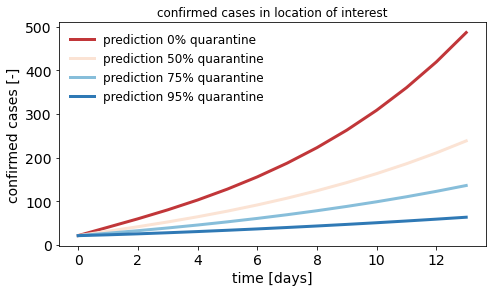

In [289]:
#%% ################### Plot results #######################################

t = np.arange(0,Tmax, dt)
days = np.arange(0,Tmax, 1)
skip = int(1/dt)

# color palette
Color_p = sns.color_palette("RdBu", 6)

fig, ax1 = plt.subplots(figsize=(500/72,300/72))


ax1.plot(days, confirmed[::skip],color = Color_p[0],lw=3,zorder=1, label=r'prediction 0% quarantine') # 
ax1.plot(days, confirmed_50[::skip],color = Color_p[2],lw=3,zorder=1, label=r'prediction 50% quarantine') #
ax1.plot(days, confirmed_75[::skip],color = Color_p[4],lw=3,zorder=1, label=r'prediction 75% quarantine') # 
ax1.plot(days, confirmed_95[::skip],color = Color_p[5],lw=3,zorder=1, label=r'prediction 95% quarantine') # 



leg = plt.legend(loc='upper left',fontsize='large',frameon=True)
leg.get_frame().set_linewidth(0.0)

ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

plt.ylabel('confirmed cases [-]',fontsize=14)
plt.xlabel('time [days]',fontsize=14)
plt.title('confirmed cases in location of interest')


plt.tight_layout()

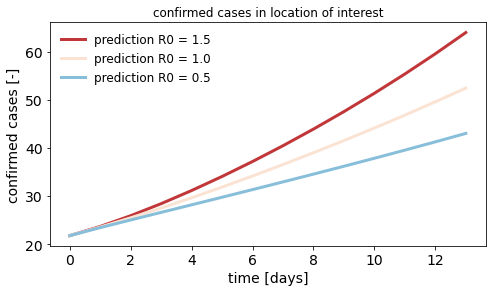

In [290]:
#%% ################### Plot results #######################################

t = np.arange(0,Tmax, dt)
days = np.arange(0,Tmax, 1)
skip = int(1/dt)

# color palette
Color_p = sns.color_palette("RdBu", 6)

fig, ax1 = plt.subplots(figsize=(500/72,300/72))


ax1.plot(days, confirmed_75_R0_1_5[::skip],color = Color_p[0],lw=3,zorder=1, label=r'prediction R0 = 1.5') # 
ax1.plot(days, confirmed_75_R0_1_0 [::skip],color = Color_p[2],lw=3,zorder=1, label=r'prediction R0 = 1.0') #
ax1.plot(days, confirmed_75_R0_0_5 [::skip],color = Color_p[4],lw=3,zorder=1, label=r'prediction R0 = 0.5') # 


leg = plt.legend(loc='upper left',fontsize='large',frameon=True)
leg.get_frame().set_linewidth(0.0)

ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

plt.ylabel('confirmed cases [-]',fontsize=14)
plt.xlabel('time [days]',fontsize=14)
plt.title('confirmed cases in location of interest')


plt.tight_layout()

# Tasks

- try switching to a different region of interest (change `idx`). How does the effect of incoming travelers on the disease dynamics change when we are looking at a state with a high population (California, Texas, ...)?

- change `R0_fin` or `fb[idx]` and observe the effect on confirmed cases
- apply quarantine only to high risk travelers (set `Flag_Iso=True`). Do the results change? How?